In [1]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
# modelName = "nvidia/mit-b0"
modelName = "doc2txt/results"
model = SegformerForSemanticSegmentation.from_pretrained(modelName,
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
model.safetensors: 100%|██████████| 15.0M/15.0M [00:12<00:00, 1.22MB/s]


In [2]:
import torch


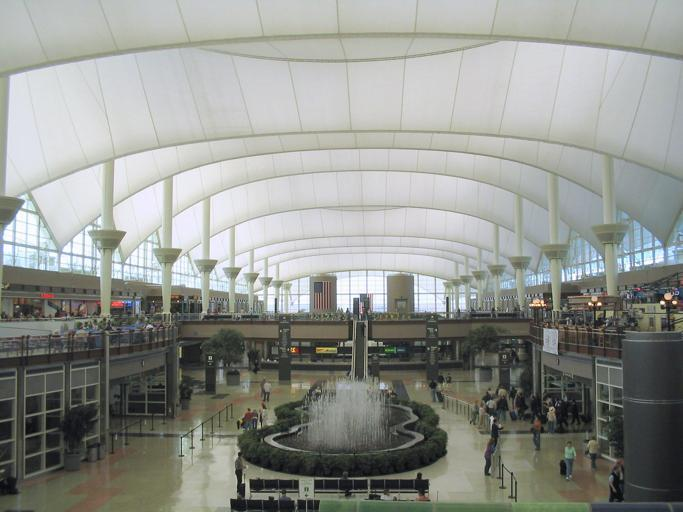

In [3]:
from PIL import Image
image = Image.open('./ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
from transformers import SegformerImageProcessor

# root_dir = './ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [7]:

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [8]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [9]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [10]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


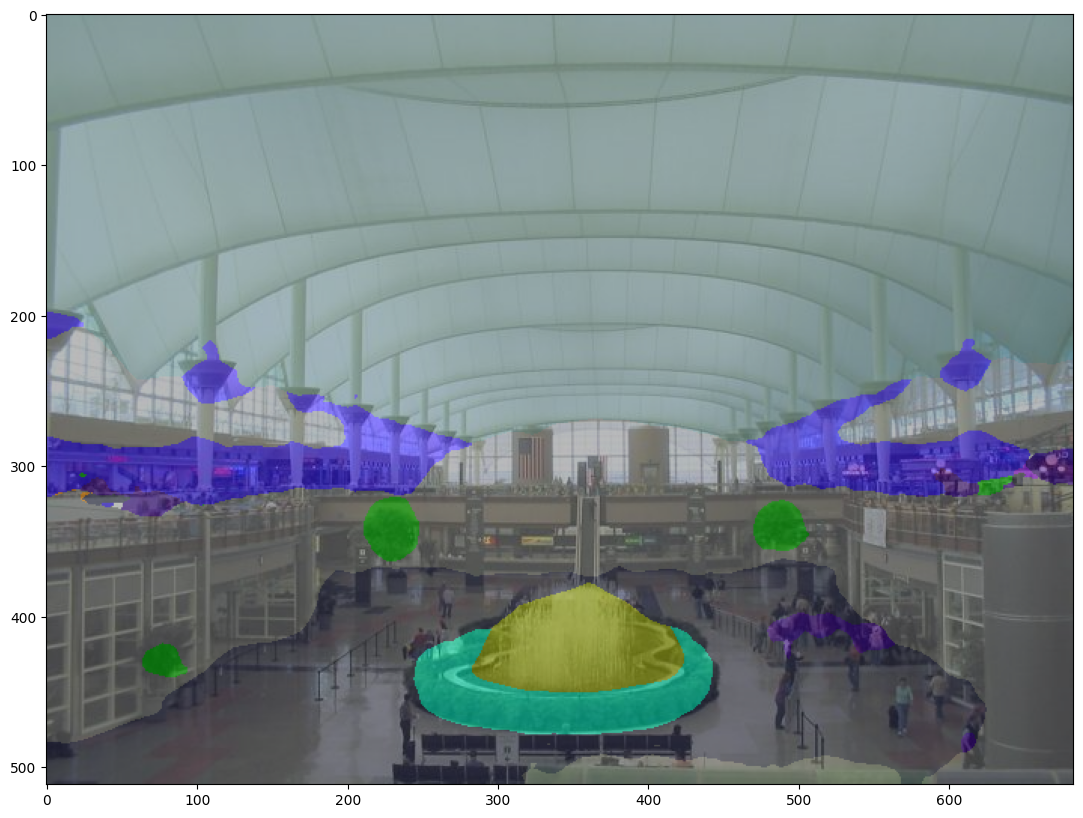

In [11]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()